In [304]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import itertools

import torch
import torch.nn as nn
import torch.optim as optim

from hypll import nn as hnn
from hypll.tensors import TangentTensor
from hypll.optim import RiemannianAdam
from hypll.manifolds.poincare_ball import Curvature, PoincareBall

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.preprocessing import LabelEncoder

In [344]:
import sys
sys.path.append('../')
import util

In [345]:
ALL = ['A_malt_all', 'A_malt_grain', 'A_malt_bread', 'A_malt_cara',
'A_malt_burn', 'A_hops_all', 'A_hops_citrus', 'A_hops_tropical',
'A_hops_noble', 'A_hops_woody', 'A_esters_all', 'A_esters_ethac',
'A_esters_isoaa', 'A_esters_flower', 'A_esters_fruity', 'F_malt_all',
'F_malt_grain', 'F_malt_bread', 'F_malt_cara', 'F_malt_burn',
'F_hops_all', 'F_hops_citrus', 'F_hops_tropical', 'F_hops_noble',
'F_hops_woody', 'F_esters_all', 'F_esters_ethac', 'F_esters_isoaa',
'F_esters_flower', 'F_esters_fruity', 'acidity', 'bitternes',
'sweetness', 'X4vg', 'diacetyl', 'dms', 'metallic', 'stale_hops', 't2n',
'orange', 'coriander', 'clove', 'lactic', 'acetic', 'barnyard',
'alcohol', 'aftertaste', 'body', 'co2', 'overall']

# LABEL_COLS = [*ALL, 'tasting_category_fine']
LABEL_COLS = ['overall', 'tasting_category_fine']

In [346]:
df_train_X = pd.read_csv('../data/beer_features_train.csv', index_col=0)
df_train_y = pd.read_csv('../data/beer_labels_panel_train.csv', index_col=0)[LABEL_COLS]
df_val_X = pd.read_csv('../data/beer_features_train.csv', index_col=0)
df_val_y = pd.read_csv('../data/beer_labels_panel_train.csv', index_col=0)[LABEL_COLS]
df_test_X = pd.read_csv('../data/beer_features_test.csv', index_col=0)
df_test_y = pd.read_csv('../data/beer_labels_panel_test.csv', index_col=0)[LABEL_COLS]

In [347]:
type_mapping = {
    'sour': ['Lambic','Flanders old brown','Brett/cofermented','Faro'],
    'kriek': ['Kriek','Fruitbeer'],
    'season': ['Saison','Christmas'],
    'strong': ['Tripel','Dubbel','Strong ale'],
    'light': ['Blond','Pils/Lager','Wheat'],
    'dark': ['Brown','Stout/Porter','Amber'],
    'hoppy': ['Hoppy'],
    'lowalc': ['Low/No alcohol'],
    'rest': ['Scotch','West Flanders ale','Brut']
    }

second_type_mapping = {
    'slight': ['sour', 'kriek', 'light'],
    'sstrong': ['season', 'strong', 'hoppy'],
    'dark': ['dark'],
    'rest': ['rest', 'lowalc']
    }

inv_type_mapping = {}
second_inv_type_mapping = {}

# Iterate through each key-value pair in the original dictionary
for key, value_list in type_mapping.items():
    for item in value_list:
        inv_type_mapping[item] = key

for key, value_list in second_type_mapping.items():
    for item in value_list:
        second_inv_type_mapping[item] = key

In [348]:
corrs_22 = np.array([
    [ 0.        ,  6.18085179,  7.34502708,  7.7764964 ,  8.00992462, 9.05009016,  6.02707005, 13.04325615,  9.52368843,  9.06429392, 6.67399324,  6.28663052,  8.7797796 ,  8.18748098,  8.21811391, 8.16731931,  8.47272834,  7.26635157,  6.44762167,  5.33487531, 7.3125352 ,  6.72220052],
    [ 6.18085179,  0.        ,  7.98680642,  4.34024195,  6.78112502, 5.43869127,  5.12651657, 10.51503274,  9.05359526,  6.12990102, 4.46727537,  5.52939289,  6.38820398,  7.4939637 ,  5.3682301 , 5.66724907,  9.41145783,  4.69221298,  4.99226125,  3.8867724 , 6.30403104,  5.08450507],
    [ 7.34502708,  7.98680642,  0.        ,  9.51227665,  9.92993515, 10.0315944,  7.34801054, 13.7418931 , 11.43829173, 10.38859187, 7.34059454,  7.16552033,  9.20724499,  8.78977429,  9.13195238, 9.37047842,  8.61218548,  9.3503591 ,  8.13100439,  6.71670262, 8.24904643,  8.78971551],
    [ 7.7764964 ,  4.34024195,  9.51227665,  0.        ,  7.65425012, 6.61350946,  6.25281518, 10.93002895,  9.21683179,  6.65061006, 6.2013066 ,  7.21540851,  7.39650576,  8.99930995,  7.30617938, 6.67507466, 10.94238991,  5.52877707,  6.43190563,  5.62289298, 8.19054038,  5.66702472],
    [ 8.00992462,  6.78112502,  9.92993515,  7.65425012,  0.        , 8.41157982,  7.50861294, 12.15054691,  9.88817706,  9.07309356, 6.5448937 ,  7.39137529,  9.40271081, 10.10634   ,  7.67838502, 8.50793139, 10.5604322 ,  7.40808743,  7.54349715,  6.89196119, 8.27831246,  7.90023589],
    [ 9.05009016,  5.43869127,  10.0315944,  6.61350946,  8.41157982, 0.        ,  7.66375717, 10.56038409, 11.21314823,  7.59231797, 6.54003704,  7.81142226,  8.25150595,  9.22798752,  6.26447023, 7.41315654, 11.18778306,  6.52471978,  7.41420113,  6.39689506, 8.42749726,  7.82608029],
    [ 6.02707005,  5.12651657,  7.34801054,  6.25281518,  7.50861294, 7.66375717,  0.        , 11.3853114 ,  9.39542525,  8.03975655, 5.73742949,  6.09220888,  7.22204474,  8.14776742,  7.69896772, 7.06341868,  8.42269018,  6.61318126,  5.70091373,  4.51204015, 7.44886439,  5.96703213],
    [ 13.0432561, 10.51503274,  13.741893 , 10.93002895,  12.1505469, 10.5603840,  11.3853114,  0.        , 13.58232934, 10.94228266, 10.91030707, 11.7078637,  11.8339897, 13.43831645, 11.50484876, 11.7552144, 14.40383648, 10.61475625, 11.38188516, 10.90831748, 12.6388850, 10.91752763],
    [ 9.52368843,  9.05359526,  11.4382917,  9.21683179,  9.88817706, 11.2131482,  9.39542525, 13.58232934,  0.        , 11.1678939 , 9.87479789,  9.98961937,  11.2202418, 12.18755575, 11.06416152, 10.6400577, 11.15130929,  9.36924977,  9.64456452,  8.76606898, 10.6875303,  9.13053391],
    [ 9.06429392,  6.12990102,  10.3885918,  6.65061006,  9.07309356, 7.59231797,  8.03975655, 10.94228266, 11.1678939 ,  0.        , 7.43044164,  8.01007074,  7.93873404,  9.3638624 ,  8.34287627, 7.96484694, 11.77341973,  6.96589961,  7.63825674,  7.22341351, 8.74269189,  7.72798731],
    [ 6.67399324,  4.46727537,  7.34059454,  6.2013066 ,  6.5448937 , 6.54003704,  5.73742949, 10.91030707,  9.87479789,  7.43044164, 0.        ,  6.02992184,  7.06857046,  7.62396068,  6.05955552, 6.31976632,  8.85314714,  5.64574155,  5.99582871,  5.01596016, 6.7405991 ,  6.45955591],
    [ 6.28663052,  5.52939289,  7.16552033,  7.21540851,  7.39137529, 7.81142226,  6.09220888, 11.70786378,  9.98961937,  8.01007074, 6.02992184,  0.        ,  8.65436807,  8.38092235,  7.05783945, 7.87258654,  9.03349712,  6.85970209,  6.42613358,  5.16455524, 6.13972352,  7.03730518],
    [ 8.7797796 ,  6.38820398,  9.20724499,  7.39650576,  9.40271081, 8.25150595,  7.22204474, 11.83398975, 11.22024188,  7.93873404, 7.06857046,  8.65436807,  0.        ,  8.40820517,  7.7842529 , 7.86620097, 10.07247376,  6.9444008 ,  7.09835303,  6.61592637, 9.61738938,  8.02566671],
    [ 8.18748098,  7.4939637 ,  8.78977429,  8.99930995,  10.10634  , 9.22798752,  8.14776742, 13.43831645, 12.18755575,  9.3638624 , 7.62396068,  8.38092235,  8.40820517,  0.        ,  8.72154835, 8.71799805, 10.03969354,  8.18944017,  8.25977754,  7.25924656, 8.66932131,  8.99971138],
    [ 8.21811391,  5.3682301 ,  9.13195238,  7.30617938,  7.67838502, 6.26447023,  7.69896772, 11.50484876, 11.06416152,  8.34287627, 6.05955552,  7.05783945,  7.7842529 ,  8.72154835,  0.        , 6.76324913, 10.35762933,  7.01692485,  6.91752998,  6.16758417, 7.55837429,  8.02377139],
    [ 8.16731931,  5.66724907,  9.37047842,  6.67507466,  8.50793139, 7.41315654,  7.06341868, 11.75521444, 10.64005778,  7.96484694, 6.31976632,  7.87258654,  7.86620097,  8.71799805,  6.76324913, 0.        , 10.29236378,  6.52560295,  7.39043046,  6.54016495, 7.82408374,  7.69141337],
    [ 8.47272834,  9.41145783,  8.61218548,  10.9423899,  10.5604322, 11.1877830,  8.42269018, 14.40383648, 11.15130929, 11.77341973, 8.85314714,  9.03349712, 10.07247376, 10.03969354, 10.35762933, 10.2923637,  0.        ,  9.65161452,  8.75706368,  8.23597036, 10.3170713,  9.89224377],
    [ 7.26635157,  4.69221298,  9.3503591 ,  5.52877707,  7.40808743, 6.52471978,  6.61318126, 10.61475625,  9.36924977,  6.96589961, 5.64574155,  6.85970209,  6.9444008 ,  8.18944017,  7.01692485, 6.52560295,  9.65161452,  0.        ,  6.09407446,  5.22564017, 8.08519695,  6.27823741],
    [ 6.44762167,  4.99226125,  8.13100439,  6.43190563,  7.54349715, 7.41420113,  5.70091373, 11.38188516,  9.64456452,  7.63825674, 5.99582871,  6.42613358,  7.09835303,  8.25977754,  6.91752998, 7.39043046,  8.75706368,  6.09407446,  0.        ,  4.82919712, 7.75382516,  5.68983059],
    [ 5.33487531,  3.8867724 ,  6.71670262,  5.62289298,  6.89196119, 6.39689506,  4.51204015, 10.90831748,  8.76606898,  7.22341351, 5.01596016,  5.16455524,  6.61592637,  7.25924656,  6.16758417, 6.54016495,  8.23597036,  5.22564017,  4.82919712,  0.        , 6.48849112,  5.50755198],
    [ 7.3125352 ,  6.30403104,  8.24904643,  8.19054038,  8.27831246, 8.42749726,  7.44886439, 12.63888501, 10.68753032,  8.74269189, 6.7405991 ,  6.13972352,  9.61738938,  8.66932131,  7.55837429, 7.82408374, 10.31707135,  8.08519695,  7.75382516,  6.48849112, 0.        ,  8.46491595],
    [ 6.72220052,  5.08450507,  8.78971551,  5.66702472,  7.90023589, 7.82608029,  5.96703213, 10.91752763,  9.13053391,  7.72798731, 6.45955591,  7.03730518,  8.02566671,  8.99971138,  8.02377139, 7.69141337,  9.89224377,  6.27823741,  5.68983059,  5.50755198, 8.46491595,  0.        ]])

corrs_9 = np.array([
    [0.        , 4.67261152, 4.11435185, 3.52617745, 7.50445088, 4.25738505, 4.95299114, 4.07949616, 3.30046451],
    [4.67261152, 0.        , 5.05331604, 4.48345282, 7.62396068, 4.35066151, 5.00508626, 4.56144693, 4.70518   ],
    [4.11435185, 5.05331604, 0.        , 3.87068934, 7.52497654, 5.04187379, 5.27313685, 4.30697579, 3.961381  ],
    [3.52617745, 4.48345282, 3.87068934, 0.        , 7.28125819, 4.76991802, 4.14605425, 3.62403585, 3.16840503],
    [7.50445088, 7.62396068, 7.52497654, 7.28125819, 0.        , 7.62723009, 8.07030905, 7.23627251, 7.16079624],
    [4.25738505, 4.35066151, 5.04187379, 4.76991802, 7.62723009, 0.        , 5.05312892, 4.97243688, 4.17526066],
    [4.95299114, 5.00508626, 5.27313685, 4.14605425, 8.07030905, 5.05312892, 0.        , 4.82795762, 4.70553276],
    [4.07949616, 4.56144693, 4.30697579, 3.62403585, 7.23627251, 4.97243688, 4.82795762, 0.        , 3.63633366],
    [3.30046451, 4.70518   , 3.961381  , 3.16840503, 7.16079624, 4.17526066, 4.70553276, 3.63633366, 0.        ]
])

corrs_4 = np.array([
    [0.        , 4.50415582, 3.19939363, 2.95745967],
    [4.50415582, 0.        , 3.92974793, 4.14904115],
    [3.19939363, 3.92974793, 0.        , 2.22635249],
    [2.95745967, 4.14904115, 2.22635249, 0.        ]
])

In [349]:
'tasting_category_fine' in df_train_y.columns

True

In [285]:
if 'tasting_category_fine' in df_train_y.columns:
    df_train_y['tasting_category_fine'] = df_train_y['tasting_category_fine'].apply(lambda type: inv_type_mapping[type])
    df_val_y['tasting_category_fine'] = df_val_y['tasting_category_fine'].apply(lambda type: inv_type_mapping[type])
    df_test_y['tasting_category_fine'] = df_test_y['tasting_category_fine'].apply(lambda type: inv_type_mapping[type])
    # df_train_y['tasting_category_fine'] = df_train_y['tasting_category_fine'].apply(lambda type: second_inv_type_mapping[inv_type_mapping[type]])
    # df_val_y['tasting_category_fine'] = df_val_y['tasting_category_fine'].apply(lambda type: second_inv_type_mapping[inv_type_mapping[type]])
    # df_test_y['tasting_category_fine'] = df_test_y['tasting_category_fine'].apply(lambda type: second_inv_type_mapping[inv_type_mapping[type]])

In [350]:
from collections import Counter
Counter(df_train_y['tasting_category_fine'].values)

Counter({'Blond': 22,
         'Tripel': 20,
         'Strong ale': 13,
         'Hoppy': 12,
         'Stout/Porter': 9,
         'Amber': 8,
         'Brown': 8,
         'Lambic': 8,
         'Pils/Lager': 8,
         'Wheat': 8,
         'Dubbel': 7,
         'Kriek': 7,
         'Saison': 7,
         'Christmas': 6,
         'Fruitbeer': 6,
         'Low/No alcohol': 6,
         'West Flanders ale': 5,
         'Brett/cofermented': 4,
         'Brut': 3,
         'Flanders old brown': 3,
         'Scotch': 3,
         'Faro': 2})

In [351]:
train_X = df_train_X.values
train_y = df_train_y.values
val_X = df_val_X.values
val_y = df_val_y.values
test_X = df_test_X.values
test_y = df_test_y.values

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape

((175, 231), (175, 2), (175, 231), (175, 2), (75, 231), (75, 2))

In [352]:
if 'tasting_category_fine' in df_train_y.columns:
    labelenc = LabelEncoder()
    train_y[:,-1] = labelenc.fit_transform(train_y[:,-1])
    print(labelenc.classes_)
    train_y = train_y.astype(np.float32)
    val_y[:,-1] = labelenc.transform(val_y[:,-1])
    val_y = val_y.astype(np.float32)
    test_y[:,-1] = labelenc.transform(test_y[:,-1])
    test_y = test_y.astype(np.float32)

['Amber' 'Blond' 'Brett/cofermented' 'Brown' 'Brut' 'Christmas' 'Dubbel'
 'Faro' 'Flanders old brown' 'Fruitbeer' 'Hoppy' 'Kriek' 'Lambic'
 'Low/No alcohol' 'Pils/Lager' 'Saison' 'Scotch' 'Stout/Porter'
 'Strong ale' 'Tripel' 'West Flanders ale' 'Wheat']


In [353]:
sum([len(v) for v in second_type_mapping.values()])

9

In [354]:
NUM_CLASSES = len(labelenc.classes_)
def generate_disctance_matrix(group_value=0.5):
    # d_matrix = np.ones([NUM_CLASSES,NUM_CLASSES]) - np.diag(np.ones(NUM_CLASSES))
    d_matrix = np.ones([NUM_CLASSES,NUM_CLASSES])

    for group in [labelenc.transform(types) for types in second_type_mapping.values()]:
        for i, x in enumerate(group):
            for j, y in enumerate(group[i:]):
                d_matrix[x,y] = group_value
                d_matrix[y,x] = group_value

    return d_matrix

In [355]:
d_matrix = generate_disctance_matrix()
for d in d_matrix:
    print(list(d))

ValueError: y contains previously unseen labels: 'sour'

In [356]:
FOLDS = 5
# NUM_SAMPLE_TYPES = len(val_X)
# NUM_SAMPLES_PER_TYPE = len(train_X) // NUM_SAMPLE_TYPES

# fold_nums = list(range(FOLDS))
# [num*NUM_SAMPLE_TYPES for num in fold_nums]
# [(num+1)*NUM_SAMPLE_TYPES for num in fold_nums]

# val_indices, train_indices = util.get_fold_indices_rand(NUM_SAMPLE_TYPES, NUM_SAMPLES_PER_TYPE, FOLDS)

# stratified by broad beertype
val_indices = np.sort([
    [23,28,54,70,75,80,133,138,143,148,153,158,102,107,169,174,0,5,36,41,124,63,68,85,30,59,89,94,45,50,114,42,98,118,165],
    [19,24,29,55,71,76,129,134,139,144,149,154,159,103,108,170,1,6,37,120,125,64,81,86,31,60,90,95,46,110,115,43,99,119,166],
    [10,15,20,25,51,56,72,77,130,135,140,145,150,155,160,104,109,171,2,7,38,121,126,65,82,87,32,61,91,47,111,116,44,100,162],
    [9,14,11,16,21,26,52,57,73,78,131,136,141,146,151,156,161,105,167,172,3,34,39,122,127,66,83,33,62,92,48,112,96,101,163],
    [8,13,18,12,17,22,27,53,69,74,79,132,137,142,147,152,157,106,168,173,164,35,40,123,128,67,84,58,88,93,49,113,97,117,4]
])

train_indices = []
for i in range(FOLDS):
    train_indices.append(np.setdiff1d(np.arange(175), val_indices[i]))

train_indices = np.sort(train_indices)

print(val_indices)
print(train_indices)

[[  0   5  23  28  30  36  41  42  45  50  54  59  63  68  70  75  80  85
   89  94  98 102 107 114 118 124 133 138 143 148 153 158 165 169 174]
 [  1   6  19  24  29  31  37  43  46  55  60  64  71  76  81  86  90  95
   99 103 108 110 115 119 120 125 129 134 139 144 149 154 159 166 170]
 [  2   7  10  15  20  25  32  38  44  47  51  56  61  65  72  77  82  87
   91 100 104 109 111 116 121 126 130 135 140 145 150 155 160 162 171]
 [  3   9  11  14  16  21  26  33  34  39  48  52  57  62  66  73  78  83
   92  96 101 105 112 122 127 131 136 141 146 151 156 161 163 167 172]
 [  4   8  12  13  17  18  22  27  35  40  49  53  58  67  69  74  79  84
   88  93  97 106 113 117 123 128 132 137 142 147 152 157 164 168 173]]
[[  1   2   3   4   6   7   8   9  10  11  12  13  14  15  16  17  18  19
   20  21  22  24  25  26  27  29  31  32  33  34  35  37  38  39  40  43
   44  46  47  48  49  51  52  53  55  56  57  58  60  61  62  64  65  66
   67  69  71  72  73  74  76  77  78  79  81  82  8

In [357]:
# Define custom PyTorch dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [358]:
import torch.nn.functional as F

class OrdinalCrossEntropyLoss(nn.Module):
    def __init__(self, d_matrix):
        super(OrdinalCrossEntropyLoss, self).__init__()
        self.d_matrix = torch.Tensor(d_matrix)

    def forward(self, inputs, targets):
        # loss = F.cross_entropy(inputs, targets, reduction='none') * torch.abs(inputs.argmax(axis=1) - targets)
        # print(inputs.shape, targets.shape)
        loss = F.cross_entropy(inputs, targets, reduction='none')
        # print(loss)
        loss *= self.d_matrix[inputs.argmax(axis=1), targets]
        # print(loss)
        return loss.mean()

In [359]:
# Define your MLP model
class HYP_MLP(nn.Module):
    def __init__(self, input_size, regr_output_size, class_output_size, layer_size, num_hidden_layers, manifold):
        super(HYP_MLP, self).__init__()
        torch.manual_seed(42)

        self.input_size = input_size
        self.regr_output_size = regr_output_size
        self.class_output_size = class_output_size

        self.fc_in = hnn.HLinear(input_size, layer_size, manifold=manifold)
        self.relu = hnn.HReLU(manifold=manifold)
        self.hidden_fcs = nn.ModuleList([hnn.HLinear(layer_size, layer_size, manifold=manifold) for _ in range(num_hidden_layers)])
        self.fc_regr_out = hnn.HLinear(layer_size, regr_output_size, manifold=manifold)
        self.fc_class_out = hnn.HLinear(layer_size, class_output_size, manifold=manifold)

    def forward(self, x):
        x = self.fc_in(x)
        x = self.relu(x)
        for fc in self.hidden_fcs:
            x = fc(x)
            x = self.relu(x)

        regr_out = self.fc_regr_out(x)

        if self.training:
            class_out = self.fc_class_out(x).tensor
            return regr_out, class_out

        return regr_out


# Define training function
def hyp_train_model(model: HYP_MLP, train_loader, regr_criterion, optimizer, manifold, device, class_criterion):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        regr_targets, class_targets = targets[:,:model.regr_output_size], targets[:,-1].to(torch.long)

        optimizer.zero_grad()

        tangents = TangentTensor(data=inputs, man_dim=-1, manifold=manifold)
        manifold_inputs = manifold.expmap(tangents)

        regr_outputs, class_outputs = model(manifold_inputs)

        regr_loss = regr_criterion(regr_outputs.tensor, regr_targets)

        class_loss = class_criterion(class_outputs.cpu(), class_targets.cpu())

        loss = regr_loss + class_loss

        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(train_loader.dataset)

In [272]:
param_grid = {
    'class_group_val': [0,0.1,0.2,0.4,0.8],
    'model_type': ['hyp'],
    'num_hidden_layers': [2],
    'layer_size': [2,4,8],
    'lr': [0.02],
    'weight_decay': [0.02],
    'batch_size': [1024],
    'epochs': [300],
    'curvature': [-1]
}


param_combinations = list(itertools.product(*param_grid.values()))
len(param_combinations)

15

In [180]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

param_eval_stats = []

for i, params in enumerate(param_combinations):
    print(f'----- Combination {i} -----')
    print(*zip(param_grid.keys(), params))
    class_group_val, model_type, num_hidden_layers, layer_size, lr, weight_decay, batch_size, epochs, curvature = params
    d_matrix = generate_disctance_matrix(class_group_val)

    for fold, (fold_train_indices, fold_val_indices) in enumerate(zip(train_indices, val_indices)):
        print(f'Fold {fold}')

        fold_train_X = train_X[fold_train_indices]
        fold_train_y = train_y[fold_train_indices]
        fold_val_X   = val_X[fold_val_indices]
        fold_val_y   = val_y[fold_val_indices]

        train_dataset = CustomDataset(fold_train_X, fold_train_y)
        val_dataset = CustomDataset(fold_val_X, fold_val_y)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        manifold = PoincareBall(c=Curvature(curvature))

        model = HYP_MLP(input_size=len(df_train_X.columns),
                        regr_output_size=len(LABEL_COLS)-1,
                        class_output_size=NUM_CLASSES,
                        layer_size=layer_size,
                        num_hidden_layers=num_hidden_layers,
                        manifold=manifold).to(device)

        regr_criterion = nn.MSELoss()
        class_criterion = OrdinalCrossEntropyLoss(d_matrix=d_matrix)

        optimizer = RiemannianAdam(model.parameters(), lr=lr, weight_decay=weight_decay)

        eval_stats = {'loss': {'train': [], 'val': []}, 'r2': {'train': [], 'val': []}}

        for epoch in range(epochs):
            eval_stats['loss']['train'].append(hyp_train_model(model, train_loader, regr_criterion,
                                                               optimizer, manifold, device, class_criterion))

            eval_stats['r2']['val'].append(util.h_evaluate_r2_double_loss(model, val_loader, manifold, device))

        print(eval_stats['r2']['val'])
        param_eval_stats.append(eval_stats)

----- Combination 0 -----
('class_group_val', 0) ('model_type', 'hyp') ('num_hidden_layers', 2) ('layer_size', 2) ('lr', 0.02) ('weight_decay', 0.02) ('batch_size', 1024) ('epochs', 300) ('curvature', -1)
Fold 0
[-0.1792811360050688, -0.07540461828067335, -0.06525503261638743, -0.059070670717118245, -0.03532528845728389, -0.019251661425163435, -0.014424562552782128, -0.011592910204896612, -0.010372886495089606, -0.010845772857165814, -0.011857565384927105, -0.012700468764484718, -0.013078289743450044, -0.01304168317353227, -0.012514812804542919, -0.011606420349510094, -0.011007630364258114, -0.009062666689533039, -0.007169819979076397, -0.005857829899914124, -0.005830920040048815, -0.006276796041511545, -0.007307787900426632, -0.009474004369255606, -0.013321874780076737, -0.016610581169279603, -0.019172418169951966, -0.021248654406553547, -0.02245486566214283, -0.02266889193914512, -0.024176259674740352, -0.02576159126893196, -0.026404616454039243, -0.027835808733185585, -0.03007056801

In [189]:
def mean_of_top(arr, n, axis=0):
    # Sort the array along the specified axis and take the last 10 values (highest)
    sorted_arr = np.sort(arr, axis=axis)
    top_values = sorted_arr.take(indices=range(-n, 0), axis=axis)

    # Compute the mean of these 10 values along the specified axis
    mean_top = np.mean(top_values, axis=axis)

    return mean_top

In [190]:
values = np.array([s['r2']['val'] for s in param_eval_stats])
values = values.reshape(len(param_grid['class_group_val']),len(param_combinations)//len(param_grid['class_group_val']),FOLDS,param_grid['epochs'][0])
# temp = []
# for vals in values:
#     temp.append(vals[:len(vals)//2])
# values = np.array(temp)

In [191]:
values.shape

(5, 3, 5, 300)

In [199]:
reduce = lambda x, axis:mean_of_top(x,3,axis)
# reduce = np.mean

In [200]:
for mult_vals in values:
    print(reduce(mult_vals, axis=1).max(axis=1).mean())

-0.0008028967027734352
-0.0014787530993186637
-0.0030602824480149664
-0.004061630169188208
-0.004071742564606962


In [201]:
best_params = []

for mult_vals in values:
    best_params.append(list(reversed(np.argsort(reduce(mult_vals, axis=1)[:,-1])[-9:])))

best_params = np.array(best_params)

In [202]:
p_comb = np.array(param_combinations)

for i, mult_best_params in enumerate(best_params):
    print(f'---- {param_grid['class_group_val'][i]} ----')
    print(p_comb[mult_best_params+int(values.shape[1]*i)])

---- 0 ----
[['0' 'hyp' '2' '2' '0.02' '0.02' '1024' '300' '-1']
 ['0' 'hyp' '2' '8' '0.02' '0.02' '1024' '300' '-1']
 ['0' 'hyp' '2' '4' '0.02' '0.02' '1024' '300' '-1']]
---- 0.1 ----
[['0.1' 'hyp' '2' '2' '0.02' '0.02' '1024' '300' '-1']
 ['0.1' 'hyp' '2' '4' '0.02' '0.02' '1024' '300' '-1']
 ['0.1' 'hyp' '2' '8' '0.02' '0.02' '1024' '300' '-1']]
---- 0.2 ----
[['0.2' 'hyp' '2' '2' '0.02' '0.02' '1024' '300' '-1']
 ['0.2' 'hyp' '2' '4' '0.02' '0.02' '1024' '300' '-1']
 ['0.2' 'hyp' '2' '8' '0.02' '0.02' '1024' '300' '-1']]
---- 0.4 ----
[['0.4' 'hyp' '2' '2' '0.02' '0.02' '1024' '300' '-1']
 ['0.4' 'hyp' '2' '4' '0.02' '0.02' '1024' '300' '-1']
 ['0.4' 'hyp' '2' '8' '0.02' '0.02' '1024' '300' '-1']]
---- 0.8 ----
[['0.8' 'hyp' '2' '2' '0.02' '0.02' '1024' '300' '-1']
 ['0.8' 'hyp' '2' '4' '0.02' '0.02' '1024' '300' '-1']
 ['0.8' 'hyp' '2' '8' '0.02' '0.02' '1024' '300' '-1']]


[[-0.02889266 -0.22262092]
 [-0.42694228 -0.59301706]
 [-0.1593629  -0.60030881]]


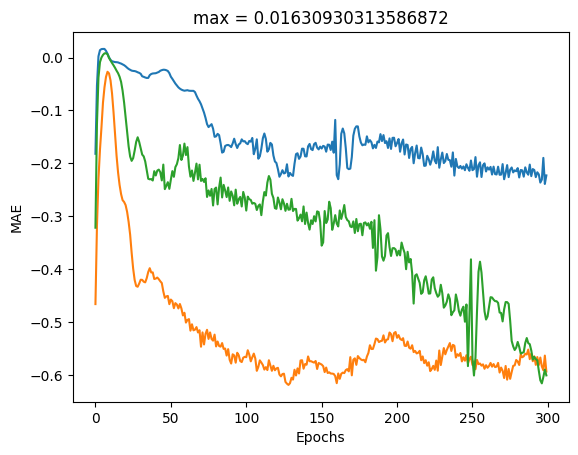

[[-0.03402749 -0.09491714]
 [-0.14925127 -0.35750788]
 [-0.42800982 -0.61372893]]


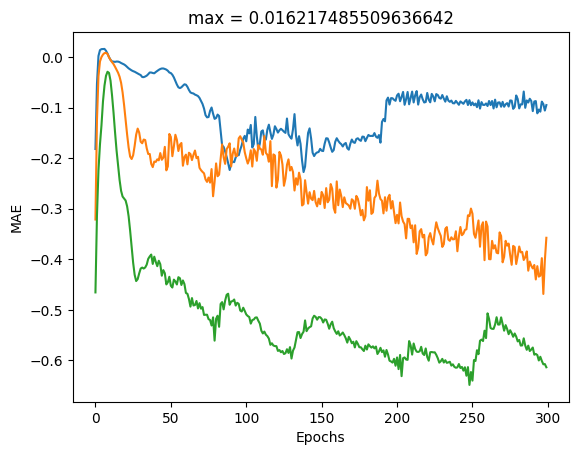

[[-0.03823722 -0.09824883]
 [-0.15553435 -0.4123795 ]
 [-0.4064045  -0.57268338]]


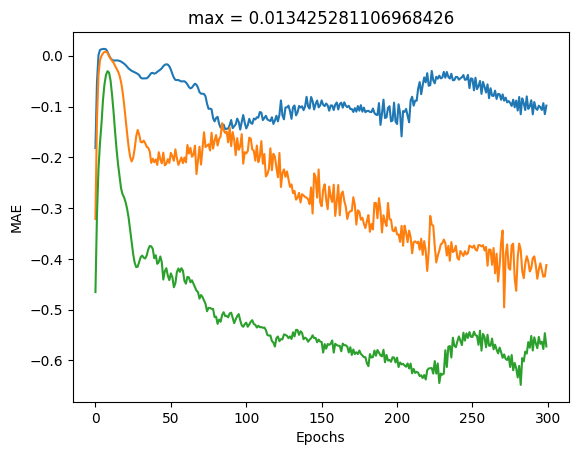

[[-0.03667997 -0.22519795]
 [-0.15991338 -0.31976888]
 [-0.40992906 -0.57432086]]


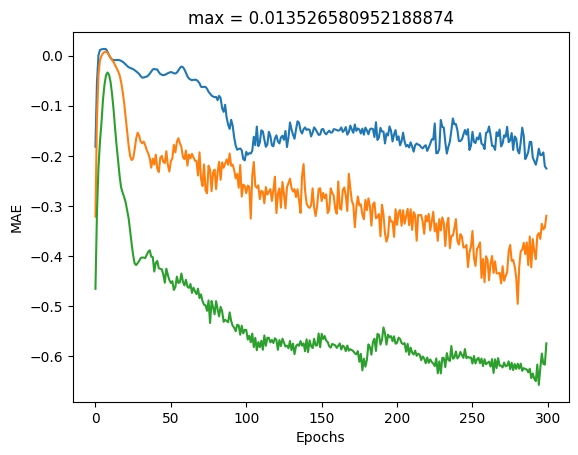

[[-0.03701608 -0.08855294]
 [-0.14903761 -0.48944031]
 [-0.44668604 -0.52492768]]


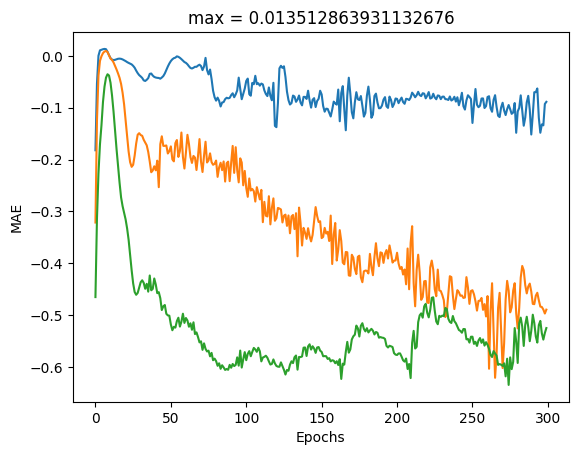

In [204]:
for mult_vals, mult_best_params in zip(values, best_params):
    best_runs = reduce(mult_vals, axis=1)[mult_best_params]
    print(best_runs[:,[29,-1]])
    for run in best_runs:
        plt.plot(run)

    plt.title(f'max = {best_runs.max()}')
    plt.ylabel('MAE')
    plt.xlabel('Epochs')

    # plt.ylim(0.03,0.07)
    # plt.yscale('log')
    plt.show()


<h1>BEST MODEL</h1>

<h3>NOTABLE STUFF</h3>


In [235]:
# 9,4 GROUPING BEER TYPES
# 0.127
all_params = {
    'class_multipliers': 0,
    'class_group_val': -1,
    'model_type': 'hyp',
    'num_hidden_layers': 1,
    'layer_size': 32,
    'lr': 0.02,
    'weight_decay': 0.005,
    'batch_size': 1024,
    'epochs': 60,
    'curvature': -1
}

# 0.141
all_params_class_22 = {
    'class_multipliers': 2,
    'class_group_val': -1,
    'model_type': 'hyp',
    'num_hidden_layers': 1,
    'layer_size': 32,
    'lr': 0.02,
    'weight_decay': 0.005,
    'batch_size': 1024,
    'epochs': 60,
    'curvature': -1
}

# 0.140
all_params_class_9 = {
    'class_multipliers': 2,
    'class_group_val': -1,
    'model_type': 'hyp',
    'num_hidden_layers': 1,
    'layer_size': 32,
    'lr': 0.02,
    'weight_decay': 0.005,
    'batch_size': 1024,
    'epochs': 60,
    'curvature': -1
}

# 0.111
all_params_class_4 = {
    'class_multipliers': 2,
    'class_group_val': -1,
    'model_type': 'hyp',
    'num_hidden_layers': 1,
    'layer_size': 32,
    'lr': 0.02,
    'weight_decay': 0.005,
    'batch_size': 1024,
    'epochs': 60,
    'curvature': -1
}

# 0.137
# all_params_ord_94 = {
#     'class_multipliers': 2,
#     'class_group_val': 0.1,
#     'model_type': 'hyp',
#     'num_hidden_layers': 1,
#     'layer_size': 32,
#     'lr': 0.02,
#     'weight_decay': 0.005,
#     'batch_size': 1024,
#     'epochs': 60,
#     'curvature': -1
# }

# 0.139
all_params_ord_22 = {
    'class_multipliers': 2,
    'class_group_val': 1,
    'model_type': 'hyp',
    'num_hidden_layers': 1,
    'layer_size': 32,
    'lr': 0.02,
    'weight_decay': 0.005,
    'batch_size': 1024,
    'epochs': 60,
    'curvature': -1
}

# 0.143
all_params_ord_9 = {
    'class_multipliers': 2,
    'class_group_val': 1,
    'model_type': 'hyp',
    'num_hidden_layers': 1,
    'layer_size': 32,
    'lr': 0.02,
    'weight_decay': 0.005,
    'batch_size': 1024,
    'epochs': 60,
    'curvature': -1
}

# 0.150
all_params_ord_4 = {
    'class_multipliers': 2,
    'class_group_val': 0.1,
    'model_type': 'hyp',
    'num_hidden_layers': 1,
    'layer_size': 32,
    'lr': 0.02,
    'weight_decay': 0.005,
    'batch_size': 1024,
    'epochs': 60,
    'curvature': -1
}

########################################################################################################################

# 0.091
overall_params = {
    'class_multipliers': 0,
    'class_group_val': -1,
    'model_type': 'hyp',
    'num_hidden_layers': 2,
    'layer_size': 4,
    'lr': 0.02,
    'weight_decay': 0.02,
    'batch_size': 1024,
    'epochs': 30,
    'curvature': -1
}

# -0.124
overall_params_class_22 = {
    'class_multipliers': 2,
    'class_group_val': -1,
    'model_type': 'hyp',
    'num_hidden_layers': 2,
    'layer_size': 4,
    'lr': 0.02,
    'weight_decay': 0.02,
    'batch_size': 1024,
    'epochs': 30,
    'curvature': -1
}

# 0.122
overall_params_class_9 = {
    'class_multipliers': 2,
    'class_group_val': -1,
    'model_type': 'hyp',
    'num_hidden_layers': 2,
    'layer_size': 4,
    'lr': 0.02,
    'weight_decay': 0.02,
    'batch_size': 1024,
    'epochs': 30,
    'curvature': -1
}

# 0.143
overall_params_class_4 = {
    'class_multipliers': 2,
    'class_group_val': -1,
    'model_type': 'hyp',
    'num_hidden_layers': 2,
    'layer_size': 4,
    'lr': 0.02,
    'weight_decay': 0.02,
    'batch_size': 1024,
    'epochs': 30,
    'curvature': -1
}

# 0.117
# overall_params_ord_94 = {
#     'class_multipliers': 2,
#     'class_group_val': 0.1,
#     'model_type': 'hyp',
#     'num_hidden_layers': 2,
#     'layer_size': 4,
#     'lr': 0.02,
#     'weight_decay': 0.02,
#     'batch_size': 1024,
#     'epochs': 30,
#     'curvature': -1
# }

# 0.035
overall_params_ord_22 = {
    'class_multipliers': 2,
    'class_group_val': 0.1,
    'model_type': 'hyp',
    'num_hidden_layers': 2,
    'layer_size': 4,
    'lr': 0.02,
    'weight_decay': 0.02,
    'batch_size': 1024,
    'epochs': 30,
    'curvature': -1
}

# 0.109
overall_params_ord_9 = {
    'class_multipliers': 2,
    'class_group_val': 0.1,
    'model_type': 'hyp',
    'num_hidden_layers': 2,
    'layer_size': 4,
    'lr': 0.02,
    'weight_decay': 0.02,
    'batch_size': 1024,
    'epochs': 30,
    'curvature': -1
}

# 0.151
overall_params_ord_4 = {
    'class_multipliers': 2,
    'class_group_val': 1,
    'model_type': 'hyp',
    'num_hidden_layers': 2,
    'layer_size': 4,
    'lr': 0.02,
    'weight_decay': 0.02,
    'batch_size': 1024,
    'epochs': 30,
    'curvature': -1
}

In [389]:
param_eval_stats = []

In [398]:
params = {
    'class_multipliers': 1,
    'class_group_val': -1,
    'model_type': 'hyp',
    'num_hidden_layers': 2,
    'layer_size': 4,
    'lr': 0.02,
    'weight_decay': 0.02,
    'batch_size': 1024,
    'epochs': 100,
    'curvature': -1
}


In [399]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_multipliers, class_group_val, model_type, num_hidden_layers, layer_size, lr, weight_decay, batch_size, epochs, curvature = params.values()

if NUM_CLASSES == 22:
    d_matrix = ((corrs_22/corrs_22.max()) + np.diag([class_group_val]*NUM_CLASSES)) * class_multipliers
elif NUM_CLASSES == 9:
    d_matrix = ((corrs_9/corrs_9.max()) + np.diag([class_group_val]*NUM_CLASSES)) * class_multipliers
elif NUM_CLASSES == 4:
    d_matrix = ((corrs_4/corrs_4.max()) + np.diag([class_group_val]*NUM_CLASSES)) * class_multipliers
else:
    d_matrix = np.ones([NUM_CLASSES,NUM_CLASSES]) * class_multipliers
if class_group_val == -1:
    d_matrix = np.ones([NUM_CLASSES,NUM_CLASSES]) * class_multipliers
print(d_matrix)
# d_matrix = generate_disctance_matrix(class_group_val)*class_multipliers

fold_train_X = train_X
fold_train_y = train_y
fold_val_X   = test_X
fold_val_y   = test_y

train_dataset = CustomDataset(fold_train_X, fold_train_y)
val_dataset = CustomDataset(fold_val_X, fold_val_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

manifold = PoincareBall(c=Curvature(curvature))

model = HYP_MLP(input_size=len(df_train_X.columns),
                regr_output_size=len(LABEL_COLS)-1,
                class_output_size=NUM_CLASSES,
                layer_size=layer_size,
                num_hidden_layers=num_hidden_layers,
                manifold=manifold).to(device)

regr_criterion = nn.MSELoss()
class_criterion = OrdinalCrossEntropyLoss(d_matrix=d_matrix)

optimizer = RiemannianAdam(model.parameters(), lr=lr, weight_decay=weight_decay)

eval_stats = {'loss': {'train': [], 'val': []}, 'r2': {'train': [], 'val': []}}

for epoch in range(epochs):
    eval_stats['loss']['train'].append(hyp_train_model(model, train_loader, regr_criterion,
                                                        optimizer, manifold, device, class_criterion))

    eval_stats['r2']['val'].append(util.h_evaluate_r2_double_loss(model, val_loader, manifold, device))

print(eval_stats['r2']['val'])
param_eval_stats.append(eval_stats)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

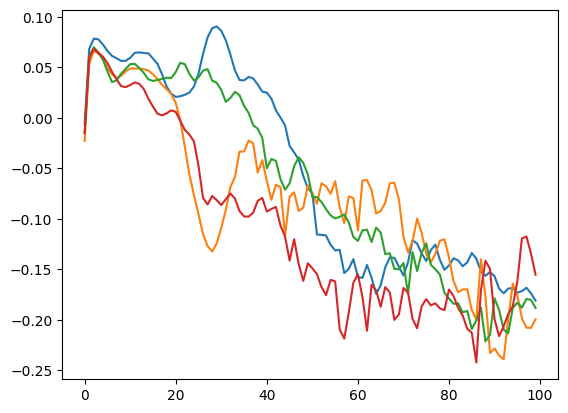

In [400]:
plt.plot(np.array([s['r2']['val'] for s in param_eval_stats]).T)
plt.show()


In [401]:
print(np.array([s['r2']['val'] for s in param_eval_stats])[:,29])
# print(np.array([s['r2']['val'] for s in param_eval_stats])[:,59])
# print(np.array([s['r2']['val'] for s in param_eval_stats])[:,-1])
# print(np.array([s['r2']['val'] for s in param_eval_stats]).max(axis=1))

[ 0.09052765 -0.12425777  0.03480546 -0.0814541 ]
